In [1]:
from tme3 import *
uspsdatatrain = "../data/USPS_train.txt"
uspsdatatest = "../data/USPS_test.txt"
alltrainx,alltrainy = load_usps(uspsdatatrain)
alltestx,alltesty = load_usps(uspsdatatest)
neg = 5
pos = 6
datax,datay = get_usps([neg,pos],alltrainx,alltrainy)
testx,testy = get_usps([neg,pos],alltestx,alltesty)


In [2]:
import numpy as np

y_train = np.where(alltrainy == 6, 1, -1)
y_test  = np.where(alltesty  == 6, 1, -1)

X_train = alltrainx.reshape(alltrainx.shape[0], -1) / 255.0
X_test  = alltestx.reshape(alltestx.shape[0], -1) / 255.0


In [3]:
from sklearn.svm import SVC

svm_lin = SVC(kernel="linear", C=1.0)
svm_rbf = SVC(kernel="rbf", C=1.0, gamma="scale")
svm_poly = SVC(kernel="poly", degree=2, C=1.0, gamma="scale", coef0=1.0)

svm_lin.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)
svm_poly.fit(X_train, y_train)

print("LIN test acc:",  svm_lin.score(X_test, y_test),  " #SV:", svm_lin.n_support_.sum())
print("RBF test acc:",  svm_rbf.score(X_test, y_test),  " #SV:", svm_rbf.n_support_.sum())
print("POLY test acc:", svm_poly.score(X_test, y_test), " #SV:", svm_poly.n_support_.sum())


LIN test acc: 0.9152964623816642  #SV: 1338
RBF test acc: 0.992526158445441  #SV: 411
POLY test acc: 0.9935226706527155  #SV: 291


In [4]:
import matplotlib.pyplot as plt

def make_grid(X, step=200, pad=0.5):
    x_min, x_max = X[:,0].min()-pad, X[:,0].max()+pad
    y_min, y_max = X[:,1].min()-pad, X[:,1].max()+pad
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, step),
                         np.linspace(y_min, y_max, step))
    grid = np.c_[xx.ravel(), yy.ravel()]
    return grid, xx, yy

def plot_frontiere_proba(X, clf, step=300, title=""):
    grid, xx, yy = make_grid(X, step=step)
    # proba classe +1 : sklearn ordonne selon clf.classes_
    proba = clf.predict_proba(grid)
    pos_index = np.where(clf.classes_ == 1)[0][0]
    zz = proba[:, pos_index].reshape(xx.shape)

    plt.contourf(xx, yy, zz, levels=30, alpha=0.6)
    plt.contour(xx, yy, zz, levels=[0.5], linewidths=2)
    plt.title(title)
    plt.grid(True)


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

param_grid = [
    {"svc__kernel": ["linear"], "svc__C": [0.1, 1, 10, 100]},
    {"svc__kernel": ["rbf"], "svc__C": [0.1, 1, 10, 100], "svc__gamma": [0.1, 1, 10, "scale"]},
    {"svc__kernel": ["poly"], "svc__C": [0.1, 1, 10], "svc__degree": [2,3], "svc__gamma": ["scale"], "svc__coef0":[0.0, 1.0]},
]

gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)
print("Test score:", gs.score(X_test, y_test))


Best params: {'svc__C': 10, 'svc__coef0': 0.0, 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}
Best CV score: 0.9949252123191655
Test score: 0.992526158445441


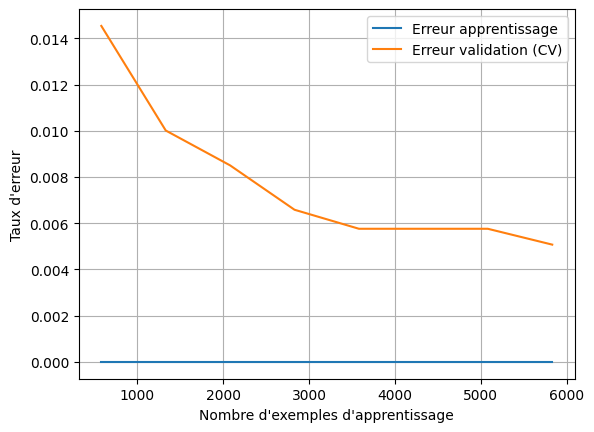

In [6]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    gs.best_estimator_, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5, n_jobs=-1
)

train_err = 1 - train_scores.mean(axis=1)
test_err  = 1 - test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_err, label="Erreur apprentissage")
plt.plot(train_sizes, test_err, label="Erreur validation (CV)")
plt.xlabel("Nombre d'exemples d'apprentissage")
plt.ylabel("Taux d'erreur")
plt.grid(True)
plt.legend()
plt.show()
